In [1]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from itertools import combinations
from collections import defaultdict

In [2]:
class PageExtractor:
    def __init__(self, preprocessors, corner_detector, output_process = False):
        assert isinstance(preprocessors, list), "List of processors expected"
        self._preprocessors = preprocessors
        self._corner_detector = corner_detector
        self.output_process = output_process


    def __call__(self, image_path):
        # Step 1: Read image from file
        self._image = cv2.imread(image_path)

        # Step 2: Preprocess image
        self._processed = self._image
        for preprocessor in self._preprocessors:
            self._processed = preprocessor(self._processed)

        self._intersections = self._corner_detector(self._processed)

        # Step 3: Deskew and extract page
        return self._extract_page()


    def _extract_page(self):
        # obtain a consistent order of the points and unpack them
        # individually
        pts = np.array([
            (x, y)
            for intersection in self._intersections
            for x, y in intersection
        ])
        rect = self._order_points(pts)
        (tl, tr, br, bl) = rect

        # compute the width of the new image, which will be the
        # maximum distance between bottom-right and bottom-left
        # x-coordiates or the top-right and top-left x-coordinates
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        # compute the height of the new image, which will be the
        # maximum distance between the top-right and bottom-right
        # y-coordinates or the top-left and bottom-left y-coordinates
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        # now that we have the dimensions of the new image, construct
        # the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
        dst = np.array([
            [0, 0],                         # Top left point
            [maxWidth - 1, 0],              # Top right point
            [maxWidth - 1, maxHeight - 1],  # Bottom right point
            [0, maxHeight - 1]],            # Bottom left point
            dtype = "float32"               # Date type
        )

        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(self._processed, M, (maxWidth, maxHeight))

        if self.output_process: cv2.imwrite('output/deskewed.jpg', warped)

        # return the warped image
        return warped

    
    def _order_points(self, pts):
        """
        Function for getting the bounding box points in the correct
        order

        Params
        pts     The points in the bounding box. Usually (x, y) coordinates

        Returns
        rect    The ordered set of points
        """
        # initialzie a list of coordinates that will be ordered such that 
        # 1st point -> Top left
        # 2nd point -> Top right
        # 3rd point -> Bottom right
        # 4th point -> Bottom left
        rect = np.zeros((4, 2), dtype = "float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        
        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        # return the ordered coordinates
        return rect

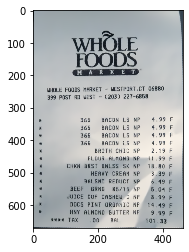

In [10]:
if __name__ == "__main__":
    import argparse
    from hough_line_corner_detector import HoughLineCornerDetector
    from processors import Resizer, OtsuThresholder, FastDenoiser

    parser = argparse.ArgumentParser(description="Python script to detect and extract documents.")

#     parser.add_argument(
#         '-i',
#         '--input-image',
#         help = "Image containing the document",
#         required = True,
#         dest = 'input_image'
#     )

    page_extractor = PageExtractor(
        preprocessors = [
            Resizer(height = 1280, output_process = True), 
            FastDenoiser(strength = 9, output_process = True)
        ],
        corner_detector = HoughLineCornerDetector(
            rho_acc = 1,
            theta_acc = 180,
            thresh = 100,
            output_process = True
        )
    )
    
    extracted = page_extractor(r'input/receipt.jpg')
    plt.imshow(extracted)
    #cv2.waitKey(0)